In [1]:
library(hdf5r)
library(Seurat)
library(purrr)
library(dplyr)
library(stringr)
library(harmony)
library(DoubletFinder)
library(ggplot2)
library(ggpubr)
library(plyr)
library(pheatmap)

Attaching SeuratObject


载入程辑包：‘purrr’


The following object is masked from ‘package:hdf5r’:

    flatten_df



载入程辑包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：Rcpp

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


载入程辑包：‘plyr’


The following object is masked from ‘package:ggpubr’:

    mutate


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




In [2]:
plasma = readRDS('~/HPV/res/public_rna/seurat_rds/plasma.rds')

In [3]:
marker_genes = c('IGHA1','IGHA2','IGHG1','IGHG3','IGHG2','IL10','MKI67')

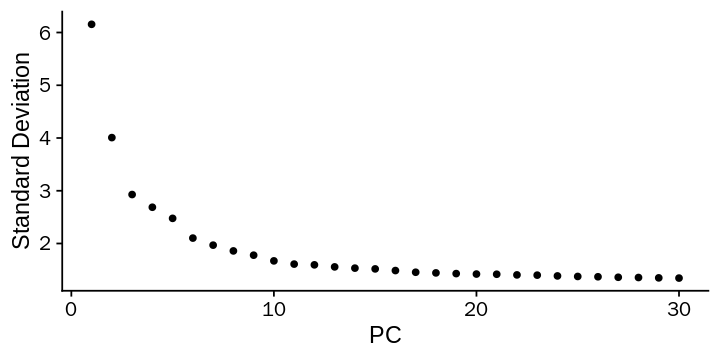

In [4]:
temp = plasma
plasma = CreateSeuratObject(counts = plasma@assays$RNA@counts, project = "plasma") %>% 
    NormalizeData(verbose = FALSE) %>%
    FindVariableFeatures(selection.method = "vst", nfeatures = 500)
VariableFeatures(plasma) = unique(c(marker_genes, plasma@assays$RNA@var.features))
plasma = ScaleData(plasma, verbose = FALSE) %>% 
    RunPCA(npcs = 30, verbose = FALSE)
options(repr.plot.width = 6, repr.plot.height = 3)
ElbowPlot(plasma,ndims = 30)

In [5]:
plasma@meta.data = temp@meta.data
plasma = RunHarmony(plasma, 'Patient', verbose = FALSE) %>%    
    RunUMAP(reduction = "harmony", dims = 1:10, verbose = FALSE) %>%
    FindNeighbors(reduction = "harmony", dims = 1:10, verbose = FALSE) %>%
    FindClusters(resolution = 0.6, verbose = FALSE)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


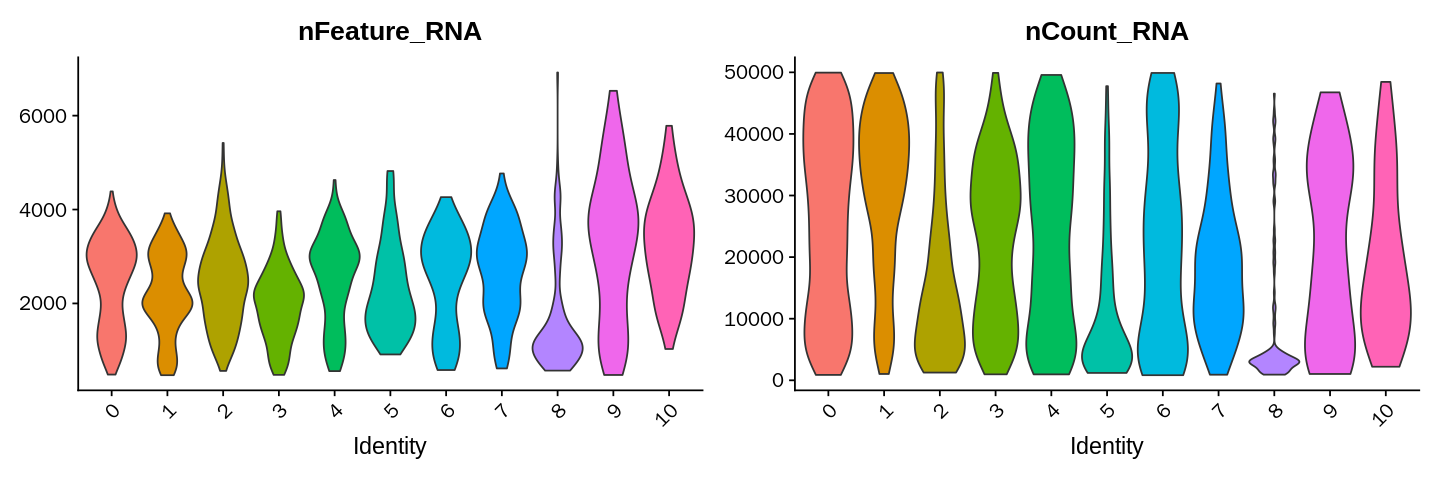

In [6]:
options(repr.plot.width = 12, repr.plot.height = 4)
VlnPlot(plasma,features = c("nFeature_RNA", "nCount_RNA"),pt.size = 0)

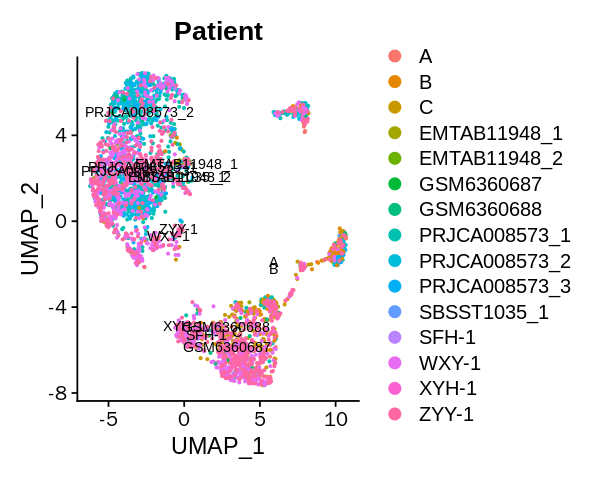

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4)
DimPlot(plasma, group.by = 'Patient',label = TRUE,label.size = 3)

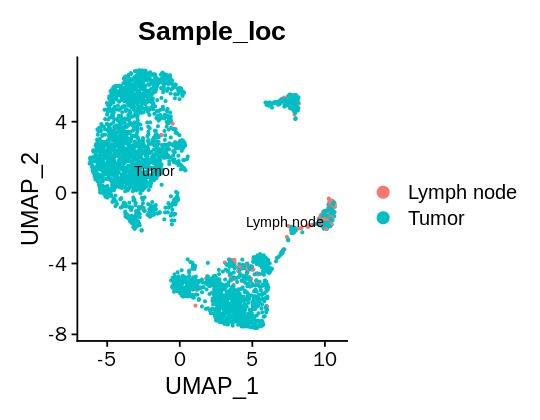

In [8]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(plasma, group.by = 'Sample_loc',label = TRUE,label.size = 3)

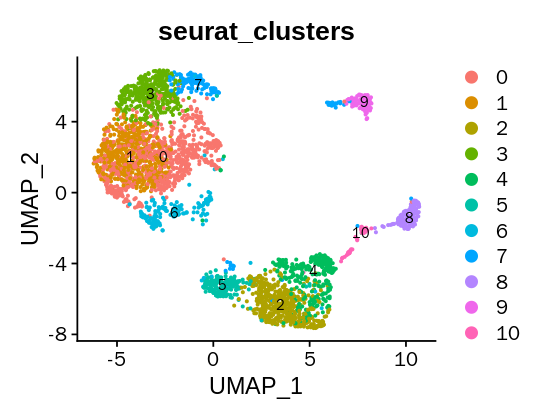

In [9]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(plasma, group.by = 'seurat_clusters',label = TRUE,label.size = 3)

In [10]:
table(plasma$seurat_clusters)


  0   1   2   3   4   5   6   7   8   9  10 
702 589 524 400 285 171 164 158 136 100  51 

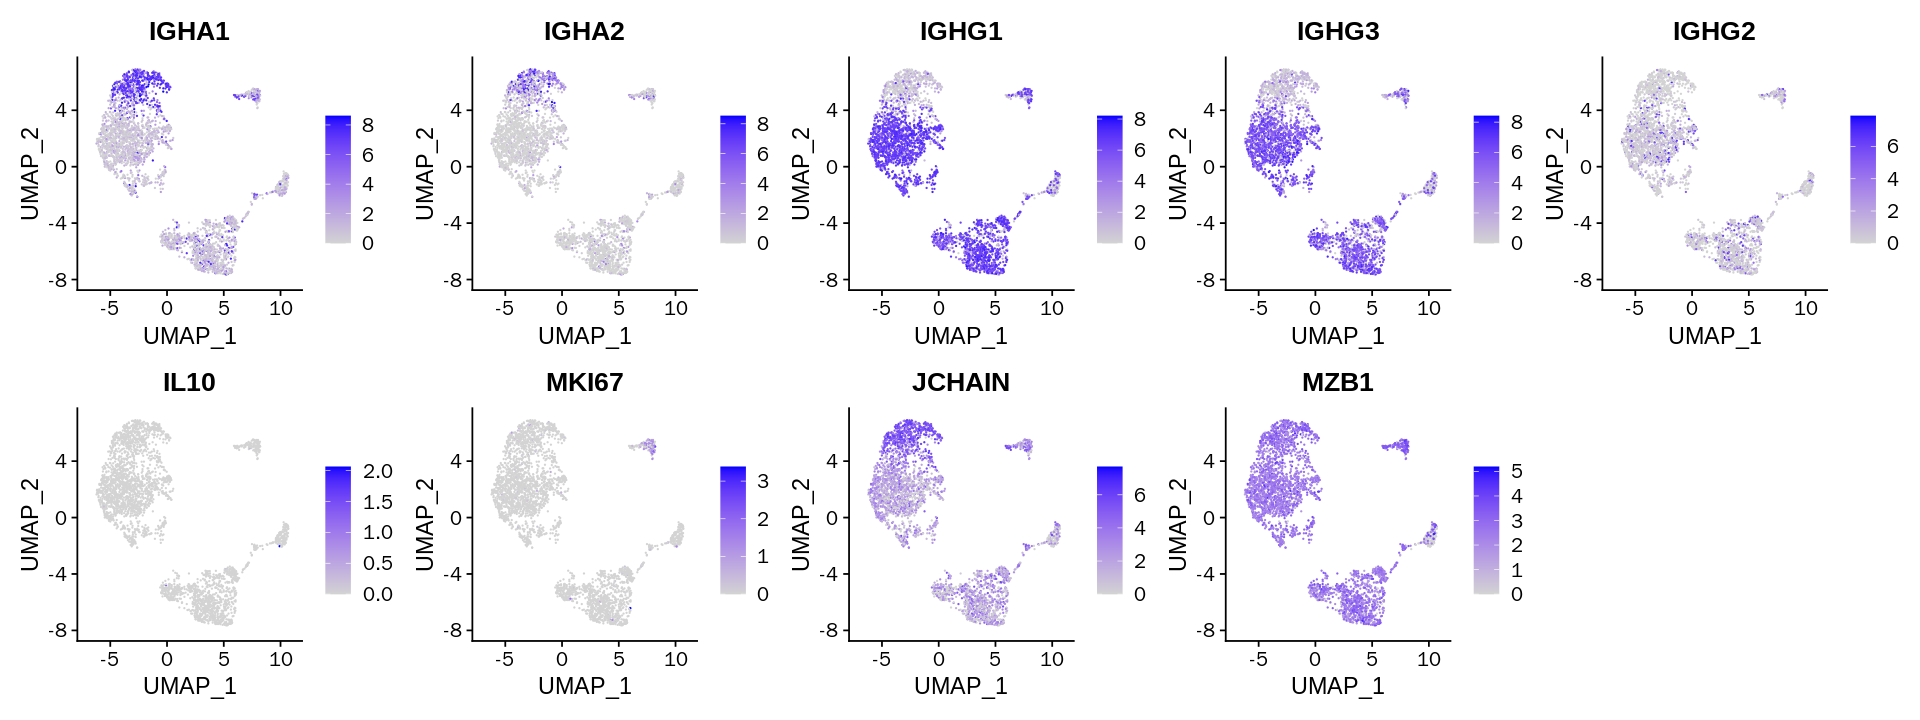

In [11]:
options(repr.plot.width = 16, repr.plot.height = 6)
FeaturePlot(plasma,features = c(marker_genes,'JCHAIN','MZB1'),ncol = 5,pt.size = 0.001)

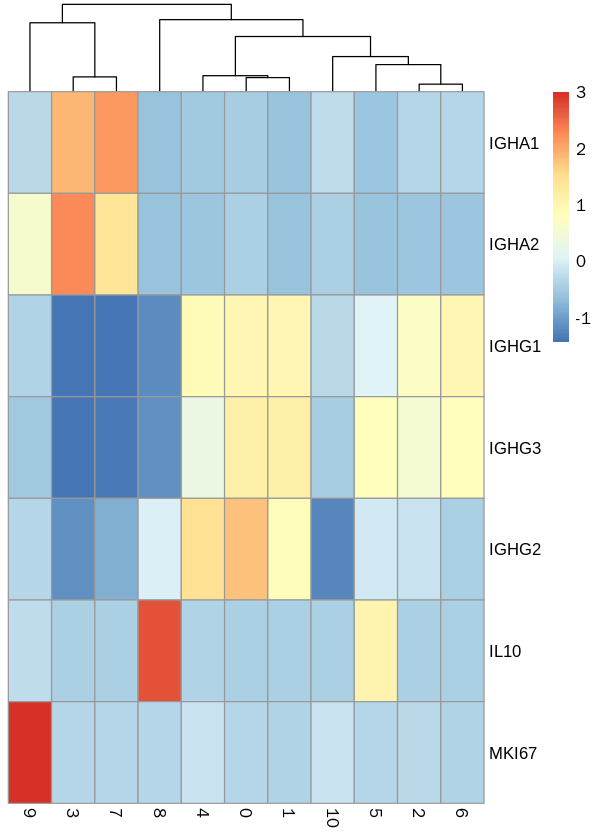

In [12]:
gene_cell_exp <- AverageExpression(plasma,
                                   features = c(marker_genes),
                                   group.by = 'seurat_clusters',
                                   slot = 'data') 
gene_cell_exp <- as.data.frame(gene_cell_exp$RNA)
marker_exp <- t(scale(t(gene_cell_exp),scale = T,center = T))
options(repr.plot.width = 5, repr.plot.height = 7)
pheatmap(marker_exp,cluster_rows = FALSE)

In [13]:
plasma$minor = 'plasma'
plasma$minor[plasma$seurat_clusters %in% c('9')] = 'Plasmablast'
plasma$minor[plasma$seurat_clusters %in% c('3','7')] = 'PC_IgA'
plasma$minor[plasma$seurat_clusters %in% c('16')] = 'PC_IgG1'
plasma$minor[plasma$seurat_clusters %in% c('1','0','6')] = 'PC_IgG1'
plasma$minor[plasma$seurat_clusters %in% c('5','2','4')] = 'PC_IgG2'
plasma$minor[plasma$seurat_clusters %in% c('8','10')] = 'PC_IgG3'

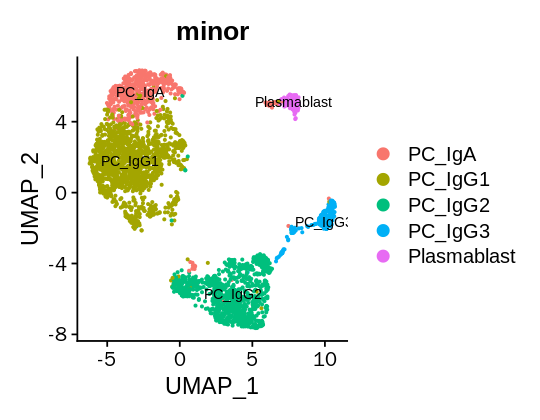

In [14]:
options(repr.plot.width = 4.5, repr.plot.height = 3.5)
DimPlot(plasma, group.by = 'minor',label = TRUE,label.size = 3)

In [15]:
saveRDS(plasma,file = '~/HPV/res/public_rna/seurat_rds/plasma.rds')